In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pip install packaging ninja
!pip install --no-index --find-links="/content/drive/MyDrive/Colab_Lib_Backup/mamba_pkg_cu126" causal-conv1d mamba-ssm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.6 MB/s eta 0:00:00
Looking in links: /content/drive/MyDrive/Colab_Lib_Backup/mamba_pkg_cu126
Processing ./drive/MyDrive/Colab_Lib_Backup/mamba_pkg_cu126/causal_conv1d-1.6.0-cp312-cp312-linux_x86_64.whl
Processing ./drive/MyDrive/Colab_Lib_Backup/mamba_pkg_cu126/mamba_ssm-2.3.0-cp312-cp312-linux_x86_64.whl


In [3]:
from mamba_ssm import Mamba2
import random
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import os
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working environment: {device}")

Working environment: cuda


In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_everything(42)

In [5]:
class Config:
    # Data Path
    file_path = "/content/drive/MyDrive/mamba2ncmapss/mamba2_processed.parquet"

    # Model Hyperparameters
    window_length = 1000
    stride = 30  # Stride for sliding window
    batch_size = 32
    num_workers = 2

    input_dim = 32
    output_dim = 1

    d_model = 4
    n_layers = 1
    d_state = 20
    d_head = 2

    learning_rate = 1e-4
    epochs = 100
    dropout=0.2

# Column Lists
input_cols = [
    'alt', 'Mach', 'TRA', 'T2',
    'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf',
    'R_T24', 'R_T30', 'R_T48', 'R_T50', 'R_P15', 'R_P2', 'R_P21', 'R_P24', 'R_Ps30', 'R_P40', 'R_P50', 'R_Nf', 'R_Nc', 'R_Wf'
]

target_cols = ['RUL']

config = Config()

In [6]:
print("Loading data...")
df = pd.read_parquet(config.file_path)

# Determine units
unique_units = df['unit'].unique()
if len(unique_units) < 2:
    raise ValueError("Dataset must have at least 2 units (one for val).")

# Last unit for validation, others for training
val_unit_id = unique_units[-1]
train_unit_ids = unique_units[:-1]

print(f"Train Units: {train_unit_ids}")
print(f"Validation Unit: {val_unit_id}")

# Train/Val Split
train_df = df[df['unit'].isin(train_unit_ids)].copy()
val_df = df[df['unit'] == val_unit_id].copy()

# Memory cleanup
del df
gc.collect()

# Normalization
# Scaler is fitted ONLY on the train set
scaler_X = StandardScaler()
scaler_y = StandardScaler()

print("Normalizing...")
# Fit_transform train data
X_train = scaler_X.fit_transform(train_df[input_cols].values)
y_train = scaler_y.fit_transform(train_df[target_cols].values)
train_meta = train_df[['unit', 'cycle']].values # Keeping metadata for sliding window logic

# Transform val data (Transform only!)
X_val = scaler_X.transform(val_df[input_cols].values)
y_val = scaler_y.transform(val_df[target_cols].values)
val_meta = val_df[['unit', 'cycle']].values

# Clear DataFrames from RAM
del train_df, val_df
gc.collect()

print("Data preparation complete.")

Loading data...
Train Units: [ 2.  5. 10. 16. 18.]
Validation Unit: 20.0
Normalizing...
Data preparation complete.


In [7]:
class LazyMambaDataset(Dataset):
    def __init__(self, X_data, y_data, meta_data, window_length, stride=1, training=False):
        """
        X_data: (N, Features)
        y_data: (N, Targets)
        meta_data: (N, 2) [unit, cycle]
        stride: Subsampling stride
        training: Boolean. If True, enables random offset generation.
        """
        self.X_data = torch.tensor(X_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)
        self.window_length = window_length
        self.stride = stride
        self.training = training

        self.groups = []

        # Pre-group metadata for fast index regeneration
        # We process this once to avoid overhead during training
        print("Grouping metadata for lazy indexing...")
        meta_df = pd.DataFrame(meta_data, columns=['unit', 'cycle'])
        for _, group in meta_df.groupby(['unit', 'cycle']):
            self.groups.append(group.index.values)

        self.valid_indices = []
        # Generate initial indices (deterministic start)
        self.generate_indices(random_offset=False)

    def generate_indices(self, random_offset=False):
        """
        Populates self.valid_indices.
        If random_offset=True, adds a random start shift in [0, stride) for each group.
        """
        self.valid_indices = []

        for indices in self.groups:
            seq_len = len(indices)
            if seq_len <= self.window_length:
                continue

            start_global_idx = indices[0]
            last_valid_start = start_global_idx + seq_len - self.window_length

            # Calculate random offset for this epoch
            offset = 0
            if random_offset and self.stride > 1:
                offset = np.random.randint(0, self.stride)

            # Ensure start + offset is within valid bounds
            # Range: [start+offset, start+offset+stride, ...]
            # Must ensure first element <= last_valid_start

            start_idx_with_offset = start_global_idx + offset

            if start_idx_with_offset <= last_valid_start:
                self.valid_indices.extend(range(start_idx_with_offset, last_valid_start + 1, self.stride))

        if random_offset:
            print(f"🔄 Data shuffled (Random Stride Offset). New size: {len(self.valid_indices)}")
        else:
            print(f"Data initialized. Size: {len(self.valid_indices)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_i = self.valid_indices[idx]
        end_i = start_i + self.window_length

        X_window = self.X_data[start_i : end_i]
        y_target = self.y_data[end_i - 1]

        return X_window, y_target

# Create Datasets
# Enable training mode for train_dataset to allow shuffling
train_dataset = LazyMambaDataset(X_train, y_train, train_meta, config.window_length, stride=config.stride, training=True)
val_dataset = LazyMambaDataset(X_val, y_val, val_meta, config.window_length, stride=5, training=False)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

Grouping metadata for lazy indexing...
Data initialized. Size: 137385
Grouping metadata for lazy indexing...
Data initialized. Size: 140477


In [8]:
class ResidualMambaBlock(nn.Module):
    """
    Standard Transformer/Mamba block structure:
    Input -> Norm -> Mamba2 -> Dropout -> Residual Connection (+ Input)
    """
    def __init__(self, config):
        super().__init__()
        self.norm = nn.LayerNorm(config.d_model)

        self.mamba = Mamba2(
            d_model=config.d_model,
            d_state=config.d_state,
            headdim=config.d_head
        )

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # Mamba2 returns a single tensor (output), not (output, cache)
        # Pre-Norm structure: x + f(norm(x))
        z = self.norm(x)
        z = self.mamba(z)
        z = self.dropout(z)
        return x + z # Skip Connection

class Mamba2Model(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Set default dropout if not in config
        if not hasattr(config, 'dropout'):
            config.dropout = 0.1

        self.embedding = nn.Linear(config.input_dim, config.d_model)
        self.emb_dropout = nn.Dropout(config.dropout)

        # Stacking blocks
        self.layers = nn.ModuleList([
            ResidualMambaBlock(config) for _ in range(config.n_layers)
        ])

        # Final Normalization (Required for Pre-norm structure)
        self.norm_f = nn.LayerNorm(config.d_model)

        # Regression head
        self.head = nn.Linear(config.d_model, config.output_dim)

    def forward(self, x):
        # x: [Batch, Window_Length, Input_Dim]

        x = self.embedding(x)
        x = self.emb_dropout(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)

        # Taking the last time step for regression
        x_last = x[:, -1, :]

        out = self.head(x_last)
        return out

model = Mamba2Model(config).to(device)
print(model)

Mamba2Model(
  (embedding): Linear(in_features=32, out_features=4, bias=True)
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (layers): ModuleList(
    (0): ResidualMambaBlock(
      (norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (mamba): Mamba2(
        (in_proj): Linear(in_features=4, out_features=60, bias=False)
        (conv1d): Conv1d(48, 48, kernel_size=(4,), stride=(1,), padding=(3,), groups=48)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=8, out_features=4, bias=False)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (norm_f): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=4, out_features=1, bias=True)
)


In [9]:
def train_loop_advanced(model, train_loader, val_loader, config):
    # Parameters
    lr_patience = 6
    weight_decay = 0.1
    max_lr_drops = 3

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, patience=lr_patience
    )

    best_val_loss = float('inf')
    lr_drop_count = 0
    best_model_path = "best_mamba2_model.pth"

    print(f"Training Started (L4 GPU - bfloat16 AMP Mode)...")

    for epoch in range(config.epochs):

        # --- SHUFFLE DATA ---
        # Regenerate indices with random offset for the training set
        if hasattr(train_loader.dataset, 'generate_indices') and train_loader.dataset.training:
            train_loader.dataset.generate_indices(random_offset=True)

        # --- TRAINING ---
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Train]")

        for batch_X, batch_y in train_pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(batch_X)
                loss = criterion(outputs.to(torch.float32), batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)

        # --- VALIDATION ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    outputs = model(batch_X)
                    loss = criterion(outputs.to(torch.float32), batch_y)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # --- LOGIC & SCHEDULER ---
        current_lr = optimizer.param_groups[0]['lr']

        print(f"\nEpoch {epoch+1} Results -> Train MSE: {avg_train_loss:.6f} | Val MSE: {avg_val_loss:.6f} | LR: {current_lr:.2e}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print("--> 🏆 New best model saved.")

        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        if new_lr < current_lr:
            lr_drop_count += 1
            print(f"--> 📉 LR reduced! ({current_lr:.2e} -> {new_lr:.2e}). Drop count: {lr_drop_count}/{max_lr_drops}")

            if lr_drop_count >= max_lr_drops:
                print("--> 🛑 Stopping training: Reached maximum LR reductions.")
                break
            else:
                print("--> ↺ Restoring best model weights...")
                model.load_state_dict(torch.load(best_model_path))
                model.to(device)

        print("-" * 50)

# Start Training
try:
    train_loop_advanced(model, train_loader, val_loader, config)
except KeyboardInterrupt:
    print("Training stopped manually.")

Training Started (L4 GPU - bfloat16 AMP Mode)...
🔄 Data shuffled (Random Stride Offset). New size: 137190


Epoch 1/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 1 Results -> Train MSE: 0.287534 | Val MSE: 0.217397 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137175


Epoch 2/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 2 Results -> Train MSE: 0.189119 | Val MSE: 0.170670 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137192


Epoch 3/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 3 Results -> Train MSE: 0.159758 | Val MSE: 0.171145 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137203


Epoch 4/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 4 Results -> Train MSE: 0.141386 | Val MSE: 0.165724 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137188


Epoch 5/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 5 Results -> Train MSE: 0.124887 | Val MSE: 0.162721 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137190


Epoch 6/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 6 Results -> Train MSE: 0.117684 | Val MSE: 0.165401 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137194


Epoch 7/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 7 Results -> Train MSE: 0.111543 | Val MSE: 0.160000 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137196


Epoch 8/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 8 Results -> Train MSE: 0.106204 | Val MSE: 0.129134 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137192


Epoch 9/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 9 Results -> Train MSE: 0.100650 | Val MSE: 0.120185 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137174


Epoch 10/100 [Train]:   0%|          | 0/4287 [01:00<?, ?it/s]


Epoch 10 Results -> Train MSE: 0.095928 | Val MSE: 0.133386 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137174


Epoch 11/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 11 Results -> Train MSE: 0.091659 | Val MSE: 0.127547 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137192


Epoch 12/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 12 Results -> Train MSE: 0.087825 | Val MSE: 0.120449 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137183


Epoch 13/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 13 Results -> Train MSE: 0.084180 | Val MSE: 0.093078 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137188


Epoch 14/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 14 Results -> Train MSE: 0.081498 | Val MSE: 0.096508 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137192


Epoch 15/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 15 Results -> Train MSE: 0.080509 | Val MSE: 0.088549 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137192


Epoch 16/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 16 Results -> Train MSE: 0.078491 | Val MSE: 0.083659 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137174


Epoch 17/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 17 Results -> Train MSE: 0.078380 | Val MSE: 0.080683 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137173


Epoch 18/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 18 Results -> Train MSE: 0.077155 | Val MSE: 0.084336 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137184


Epoch 19/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 19 Results -> Train MSE: 0.076749 | Val MSE: 0.081222 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137190


Epoch 20/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 20 Results -> Train MSE: 0.076400 | Val MSE: 0.079097 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137196


Epoch 21/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e62142a74c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e62142a74c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 21 Results -> Train MSE: 0.075959 | Val MSE: 0.082784 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137176


Epoch 22/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 22 Results -> Train MSE: 0.075227 | Val MSE: 0.080061 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137178


Epoch 23/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 23 Results -> Train MSE: 0.074640 | Val MSE: 0.078520 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137193


Epoch 24/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 24 Results -> Train MSE: 0.074333 | Val MSE: 0.078386 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137194


Epoch 25/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 25 Results -> Train MSE: 0.073981 | Val MSE: 0.077517 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137186


Epoch 26/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 26 Results -> Train MSE: 0.073133 | Val MSE: 0.077698 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137192


Epoch 27/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 27 Results -> Train MSE: 0.073049 | Val MSE: 0.081651 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137190


Epoch 28/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 28 Results -> Train MSE: 0.072756 | Val MSE: 0.077237 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137198


Epoch 29/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 29 Results -> Train MSE: 0.072728 | Val MSE: 0.074674 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137178


Epoch 30/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 30 Results -> Train MSE: 0.072150 | Val MSE: 0.080793 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137190


Epoch 31/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 31 Results -> Train MSE: 0.072347 | Val MSE: 0.074501 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137179


Epoch 32/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 32 Results -> Train MSE: 0.072159 | Val MSE: 0.076866 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137193


Epoch 33/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 33 Results -> Train MSE: 0.071872 | Val MSE: 0.083367 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137192


Epoch 34/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 34 Results -> Train MSE: 0.071780 | Val MSE: 0.079426 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137188


Epoch 35/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 35 Results -> Train MSE: 0.071472 | Val MSE: 0.074881 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137168


Epoch 36/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 36 Results -> Train MSE: 0.071133 | Val MSE: 0.083180 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137189


Epoch 37/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 37 Results -> Train MSE: 0.071086 | Val MSE: 0.084004 | LR: 1.00e-04
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137197


Epoch 38/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 38 Results -> Train MSE: 0.070421 | Val MSE: 0.076171 | LR: 1.00e-04
--> 📉 LR reduced! (1.00e-04 -> 2.00e-05). Drop count: 1/3
--> ↺ Restoring best model weights...
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137190


Epoch 39/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 39 Results -> Train MSE: 0.069430 | Val MSE: 0.080162 | LR: 2.00e-05
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137171


Epoch 40/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 40 Results -> Train MSE: 0.069469 | Val MSE: 0.074434 | LR: 2.00e-05
--> 🏆 New best model saved.
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137178


Epoch 41/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 41 Results -> Train MSE: 0.069104 | Val MSE: 0.078158 | LR: 2.00e-05
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137168


Epoch 42/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 42 Results -> Train MSE: 0.068847 | Val MSE: 0.076428 | LR: 2.00e-05
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137186


Epoch 43/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 43 Results -> Train MSE: 0.068981 | Val MSE: 0.079993 | LR: 2.00e-05
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137196


Epoch 44/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]


Epoch 44 Results -> Train MSE: 0.069305 | Val MSE: 0.082899 | LR: 2.00e-05
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137172


Epoch 45/100 [Train]:   0%|          | 0/4287 [00:00<?, ?it/s]


Epoch 45 Results -> Train MSE: 0.068560 | Val MSE: 0.082942 | LR: 2.00e-05
--------------------------------------------------
🔄 Data shuffled (Random Stride Offset). New size: 137210


Epoch 46/100 [Train]:   0%|          | 0/4288 [00:00<?, ?it/s]

Training stopped manually.


Loading Test Data from /content/drive/MyDrive/mamba2ncmapss/mamba2_processed_TEST.parquet...
Normalizing Test Data...
Grouping metadata for lazy indexing...
Data initialized. Size: 1051945
Loading Best Model...
Loaded weights from 'best_mamba2_model.pth'
Running Inference on Test Set...


Testing:   0%|          | 0/32874 [00:00<?, ?it/s]

Inverse transforming predictions...
Applying floor to predictions...

Test RMSE: 5.3858


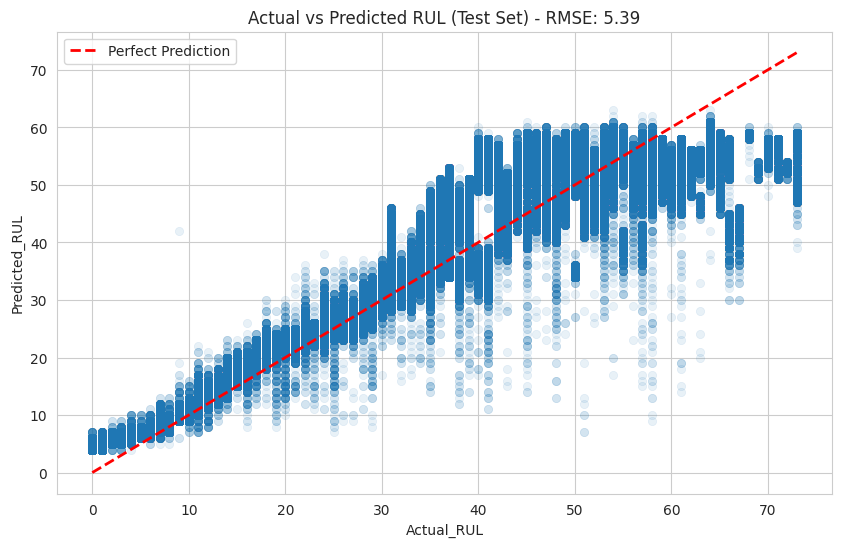

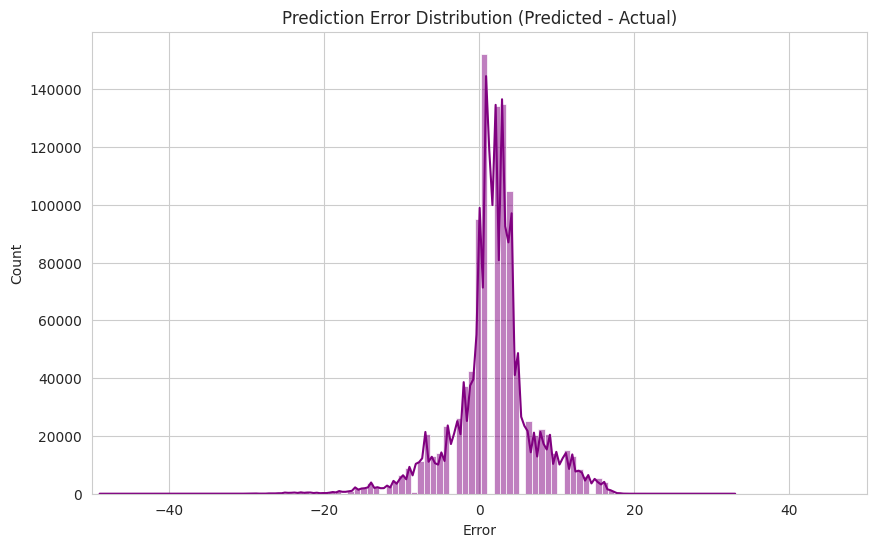

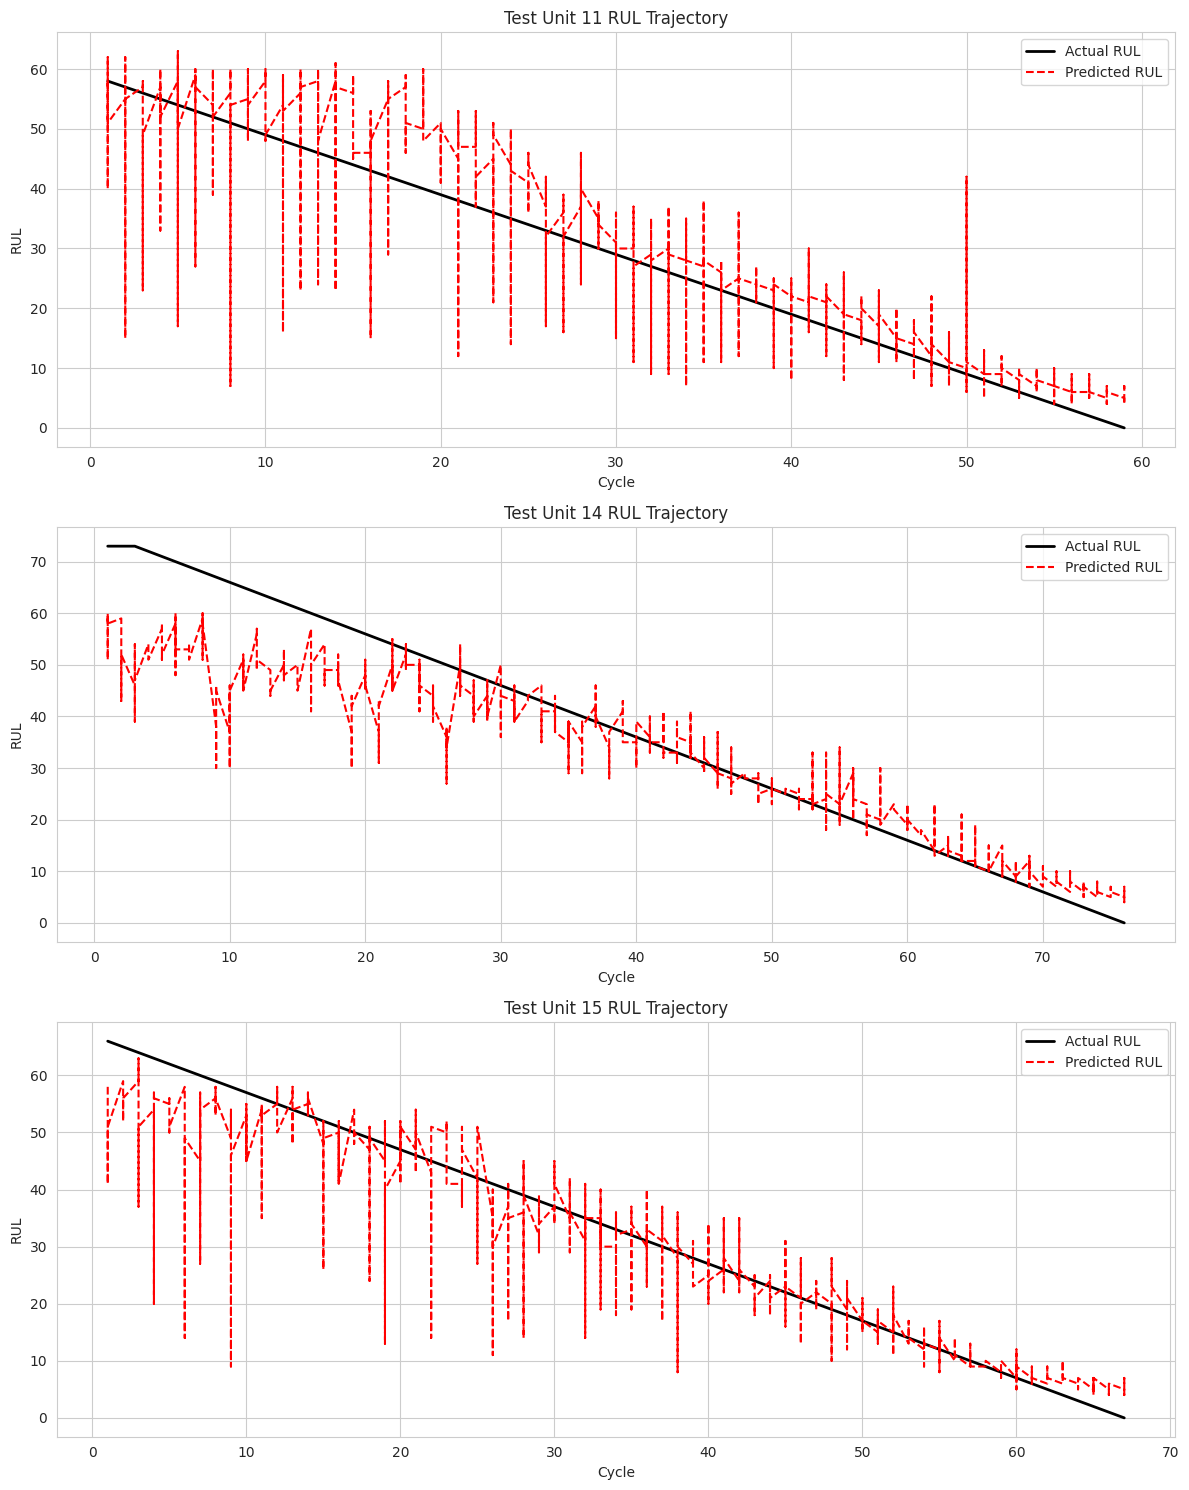

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Test Data ---
test_file_path = "/content/drive/MyDrive/mamba2ncmapss/mamba2_processed_TEST.parquet"
print(f"Loading Test Data from {test_file_path}...")
test_df = pd.read_parquet(test_file_path)

# --- 2. Preprocess ---
# Using the global scaler_X and scaler_Y fitted on training data
# and input_cols defined in Config (ensure 'cycle' is removed if you ran the previous fix)
print("Normalizing Test Data...")

# Ensure columns match
missing_cols = set(input_cols) - set(test_df.columns)
if missing_cols:
    raise ValueError(f"Missing columns in test data: {missing_cols}")

X_test = scaler_X.transform(test_df[input_cols].values)
y_test = scaler_y.transform(test_df[target_cols].values)
test_meta = test_df[['unit', 'cycle']].values

# Clear raw df to save memory
del test_df
gc.collect()

# --- 3. Create Dataset & Loader ---
# Using the existing LazyMambaDataset class
test_dataset = LazyMambaDataset(X_test, y_test, test_meta, config.window_length)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

# --- 4. Load Best Model ---
print("Loading Best Model...")
model = Mamba2Model(config).to(device)

try:
    model.load_state_dict(torch.load("best_mamba2_model.pth"))
    print("Loaded weights from 'best_mamba2_model.pth'")
except FileNotFoundError:
    print("Warning: 'best_mamba2_model.pth' not found. Using current model weights.")

model.eval()

# --- 5. Inference ---
print("Running Inference on Test Set...")
preds = []
targets = []

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc="Testing"):
        batch_X = batch_X.to(device)

        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            outputs = model(batch_X)

        # Move to CPU
        preds.append(outputs.float().cpu().numpy())
        targets.append(batch_y.float().cpu().numpy())

# Concatenate results
preds = np.concatenate(preds)
targets = np.concatenate(targets)

# --- 6. Inverse Transform ---
print("Inverse transforming predictions...")
preds_inv = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
targets_inv = scaler_y.inverse_transform(targets.reshape(-1, 1)).flatten()

# --- APPLY FLOORING ---
# Round down predictions as requested (e.g. 61.9 -> 61.0)
print("Applying floor to predictions...")
preds_inv = np.floor(preds_inv)

# --- 7. Prepare Results DataFrame ---
# Reconstruct Unit/Cycle info for plotting
# The dataset stores valid start indices. The target corresponds to start + window_length - 1
valid_indices_arr = np.array(test_dataset.valid_indices)
target_indices = valid_indices_arr + config.window_length - 1

pred_units = test_meta[target_indices, 0]
pred_cycles = test_meta[target_indices, 1]

results_df = pd.DataFrame({
    'Unit': pred_units,
    'Cycle': pred_cycles,
    'Actual_RUL': targets_inv,
    'Predicted_RUL': preds_inv
})

# Calculate Metrics
mse = np.mean((results_df['Actual_RUL'] - results_df['Predicted_RUL'])**2)
rmse = np.sqrt(mse)
print(f"\nTest RMSE: {rmse:.4f}")

# --- 8. Visualizations ---
sns.set_style("whitegrid")

# Plot A: Predicted vs Actual Scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual_RUL', y='Predicted_RUL', data=results_df, alpha=0.1, edgecolor=None)
plt.plot([results_df['Actual_RUL'].min(), results_df['Actual_RUL'].max()],
         [results_df['Actual_RUL'].min(), results_df['Actual_RUL'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title(f'Actual vs Predicted RUL (Test Set) - RMSE: {rmse:.2f}')
plt.legend()
plt.show()

# Plot B: Error Histogram
plt.figure(figsize=(10, 6))
results_df['Error'] = results_df['Predicted_RUL'] - results_df['Actual_RUL']
sns.histplot(results_df['Error'], kde=True, bins=100, color='purple')
plt.title('Prediction Error Distribution (Predicted - Actual)')
plt.xlabel('Error')
plt.xlim(-50, 50) # Zoom in to see the peak
plt.show()

# Plot C: Trajectories for Sample Units
unique_test_units = results_df['Unit'].unique()
plot_units = unique_test_units[:4] # Plot first 4 units

fig, axes = plt.subplots(len(plot_units), 1, figsize=(12, 5 * len(plot_units)), sharex=False)
if len(plot_units) == 1: axes = [axes]

for i, unit in enumerate(plot_units):
    unit_data = results_df[results_df['Unit'] == unit]
    ax = axes[i]
    ax.plot(unit_data['Cycle'], unit_data['Actual_RUL'], label='Actual RUL', color='black', linewidth=2)
    ax.plot(unit_data['Cycle'], unit_data['Predicted_RUL'], label='Predicted RUL', color='red', linestyle='--')
    ax.set_title(f'Test Unit {int(unit)} RUL Trajectory')
    ax.set_ylabel('RUL')
    ax.set_xlabel('Cycle')
    ax.legend()

plt.tight_layout()
plt.show()